In [6]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [7]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES_LEVEL2 = 17

subkategori_ke_level1 = [0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0]
label_level2_map = {
    0: 'Cangkang Telur', 1: 'Elektronik', 2: 'Kaca', 3: 'Kain', 4: 'Kardus', 5: 'Karet',
    6: 'Kayu', 7: 'Kertas', 8: 'Kotoran Hewan', 9: 'Logam', 10: 'Plastik', 11: 'Sepatu',
    12: 'Sisa Buah', 13: 'Sisa Teh Kopi', 14: 'Sisa makanan', 15: 'Styrofoam', 16: 'Tumbuhan'
}

train_dir = r'C:\Users\muham\OneDrive\Documents\KULIAH SEMESTER 6\KP\Project KP\Dataset Beneran\train'
val_dir = r'C:\Users\muham\OneDrive\Documents\KULIAH SEMESTER 6\KP\Project KP\Dataset Beneran\val'

In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)

train_gen_base = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)
val_gen_base = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

def multi_output_generator(generator):
    while True:
        x, y_level2 = next(generator)
        y_indices = np.argmax(y_level2, axis=1)
        y_level1 = np.array([subkategori_ke_level1[idx] for idx in y_indices]).reshape(-1, 1)
        yield x, {'level1': y_level1, 'level2': y_level2}

train_gen = multi_output_generator(train_gen_base)
val_gen = multi_output_generator(val_gen_base)

Found 8260 images belonging to 17 classes.
Found 2055 images belonging to 17 classes.


In [9]:
base_model = MobileNetV2(input_shape=(224,224,3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze backbone

inputs = Input(shape=(224,224,3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
level1_output = Dense(1, activation='sigmoid', name='level1')(x)
level2_output = Dense(NUM_CLASSES_LEVEL2, activation='softmax', name='level2')(x)

model = Model(inputs=inputs, outputs=[level1_output, level2_output])
model.compile(
    optimizer=Adam(),
    loss={'level1': 'binary_crossentropy', 'level2': 'categorical_crossentropy'},
    metrics={'level1': 'accuracy', 'level2': 'accuracy'}
)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_2… │ (None, 7, 7,      │  2,257,984 │ input_layer_1[0]… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ mobilenetv2_1.00… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1280)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ level1 (Dense)      │ (None, 1)         │      1,281 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ level2 (Dense)      │ (None, 17)        │     21,777 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,281,042 (8.70 MB)

 Trainable params: 23,058 (90.07 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [10]:
EPOCHS = 40
steps_per_epoch = train_gen_base.samples // BATCH_SIZE
validation_steps = val_gen_base.samples // BATCH_SIZE

early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
model_ckpt = ModelCheckpoint('best_model_mobilenetv2.h5', save_best_only=True, monitor='val_loss')

history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=validation_steps,
    epochs=EPOCHS,
    callbacks=[early_stop, model_ckpt]
)

Epoch 1/40
176/258 ━━━━━━━━━━━━━━━━━━━━ 1:04 788ms/step - level1_accuracy: 0.7258 - level1_loss: 0.5553 - level2_accuracy: 0.2690 - level2_loss: 2.5471 - loss: 3.1025

c:\Users\muham\anaconda3\envs\tfenv\lib\site-packages\PIL\Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 754ms/step - level1_accuracy: 0.7540 - level1_loss: 0.5101 - level2_accuracy: 0.3229 - level2_loss: 2.3313 - loss: 2.8414

258/258 ━━━━━━━━━━━━━━━━━━━━ 221s 841ms/step - level1_accuracy: 0.7543 - level1_loss: 0.5097 - level2_accuracy: 0.3234 - level2_loss: 2.3291 - loss: 2.8388 - val_level1_accuracy: 0.9004 - val_level1_loss: 0.2478 - val_level2_accuracy: 0.6934 - val_level2_loss: 0.9625 - val_loss: 1.2104
Epoch 2/40
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - level1_accuracy: 0.8870 - level1_loss: 0.2783 - level2_accuracy: 0.6480 - level2_loss: 1.1283 - loss: 1.4124

258/258 ━━━━━━━━━━━━━━━━━━━━ 154s 598ms/step - level1_accuracy: 0.8870 - level1_loss: 0.2783 - level2_accuracy: 0.6480 - level2_loss: 1.1282 - loss: 1.4123 - val_level1_accuracy: 0.9121 - val_level1_loss: 0.2158 - val_level2_accuracy: 0.7485 - val_level2_loss: 0.7810 - val_loss: 0.9969
Epoch 3/40
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - level1_accuracy: 0.8941 - level1_loss: 0.2628 - level2_accuracy: 0.6896 - level2_loss: 0.9243 - loss: 1.1944

258/258 ━━━━━━━━━━━━━━━━━━━━ 153s 596ms/step - level1_accuracy: 0.8941 - level1_loss: 0.2628 - level2_accuracy: 0.6896 - level2_loss: 0.9243 - loss: 1.1944 - val_level1_accuracy: 0.9102 - val_level1_loss: 0.2163 - val_level2_accuracy: 0.7529 - val_level2_loss: 0.7536 - val_loss: 0.9699
Epoch 4/40
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 547ms/step - level1_accuracy: 0.9004 - level1_loss: 0.2501 - level2_accuracy: 0.7109 - level2_loss: 0.8752 - loss: 1.1337

258/258 ━━━━━━━━━━━━━━━━━━━━ 160s 620ms/step - level1_accuracy: 0.9004 - level1_loss: 0.2501 - level2_accuracy: 0.7109 - level2_loss: 0.8752 - loss: 1.1337 - val_level1_accuracy: 0.9071 - val_level1_loss: 0.2335 - val_level2_accuracy: 0.7632 - val_level2_loss: 0.7201 - val_loss: 0.9375
Epoch 5/40
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - level1_accuracy: 0.8983 - level1_loss: 0.2488 - level2_accuracy: 0.7237 - level2_loss: 0.8434 - loss: 1.0906

258/258 ━━━━━━━━━━━━━━━━━━━━ 148s 576ms/step - level1_accuracy: 0.8983 - level1_loss: 0.2488 - level2_accuracy: 0.7237 - level2_loss: 0.8434 - loss: 1.0906 - val_level1_accuracy: 0.9130 - val_level1_loss: 0.2094 - val_level2_accuracy: 0.7657 - val_level2_loss: 0.7206 - val_loss: 0.9127
Epoch 6/40
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - level1_accuracy: 0.9104 - level1_loss: 0.2336 - level2_accuracy: 0.7273 - level2_loss: 0.8577 - loss: 1.0738

258/258 ━━━━━━━━━━━━━━━━━━━━ 145s 564ms/step - level1_accuracy: 0.9103 - level1_loss: 0.2336 - level2_accuracy: 0.7273 - level2_loss: 0.8576 - loss: 1.0737 - val_level1_accuracy: 0.9071 - val_level1_loss: 0.2269 - val_level2_accuracy: 0.7805 - val_level2_loss: 0.6985 - val_loss: 0.9103
Epoch 7/40
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - level1_accuracy: 0.9078 - level1_loss: 0.2339 - level2_accuracy: 0.7312 - level2_loss: 0.7945 - loss: 1.0401

258/258 ━━━━━━━━━━━━━━━━━━━━ 145s 564ms/step - level1_accuracy: 0.9078 - level1_loss: 0.2339 - level2_accuracy: 0.7312 - level2_loss: 0.7945 - loss: 1.0401 - val_level1_accuracy: 0.9174 - val_level1_loss: 0.1951 - val_level2_accuracy: 0.7761 - val_level2_loss: 0.6889 - val_loss: 0.8690
Epoch 8/40
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - level1_accuracy: 0.9163 - level1_loss: 0.2233 - level2_accuracy: 0.7459 - level2_loss: 0.7690 - loss: 1.0031

258/258 ━━━━━━━━━━━━━━━━━━━━ 145s 564ms/step - level1_accuracy: 0.9163 - level1_loss: 0.2234 - level2_accuracy: 0.7458 - level2_loss: 0.7691 - loss: 1.0032 - val_level1_accuracy: 0.9174 - val_level1_loss: 0.2084 - val_level2_accuracy: 0.7889 - val_level2_loss: 0.6677 - val_loss: 0.8531
Epoch 9/40
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - level1_accuracy: 0.9108 - level1_loss: 0.2208 - level2_accuracy: 0.7299 - level2_loss: 0.8110 - loss: 1.0303

258/258 ━━━━━━━━━━━━━━━━━━━━ 168s 653ms/step - level1_accuracy: 0.9108 - level1_loss: 0.2208 - level2_accuracy: 0.7299 - level2_loss: 0.8109 - loss: 1.0302 - val_level1_accuracy: 0.9120 - val_level1_loss: 0.2007 - val_level2_accuracy: 0.7909 - val_level2_loss: 0.6533 - val_loss: 0.8344
Epoch 10/40
258/258 ━━━━━━━━━━━━━━━━━━━━ 231s 897ms/step - level1_accuracy: 0.9004 - level1_loss: 0.2496 - level2_accuracy: 0.7477 - level2_loss: 0.7823 - loss: 1.0221 - val_level1_accuracy: 0.9155 - val_level1_loss: 0.2109 - val_level2_accuracy: 0.7776 - val_level2_loss: 0.6957 - val_loss: 0.8929
Epoch 11/40
258/258 ━━━━━━━━━━━━━━━━━━━━ 202s 785ms/step - level1_accuracy: 0.9093 - level1_loss: 0.2283 - level2_accuracy: 0.7478 - level2_loss: 0.8108 - loss: 1.0226 - val_level1_accuracy: 0.9056 - val_level1_loss: 0.2336 - val_level2_accuracy: 0.7741 - val_level2_loss: 0.7071 - val_loss: 0.9271
Epoch 12/40
258/258 ━━━━━━━━━━━━━━━━━━━━ 184s 716ms/step - level1_accuracy: 0.9052 - level1_loss: 0.2425 - level2_a

In [11]:
# Unfreeze seluruh backbone (atau hanya beberapa layer terakhir untuk lebih hati-hati)
base_model.trainable = True

# Opsional: Hanya fine-tune beberapa layer terakhir (misal 30 layer)
# for layer in base_model.layers[:-30]:
#     layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=1e-4),  # lr kecil saat fine-tune
    loss={'level1': 'binary_crossentropy', 'level2': 'categorical_crossentropy'},
    metrics={'level1': 'accuracy', 'level2': 'accuracy'}
)

history_ft = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=validation_steps,
    epochs=15,
    callbacks=[early_stop, model_ckpt]
)

Epoch 1/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 646s 2s/step - level1_accuracy: 0.8917 - level1_loss: 0.2790 - level2_accuracy: 0.6431 - level2_loss: 1.1652 - loss: 1.4442 - val_level1_accuracy: 0.9288 - val_level1_loss: 0.1928 - val_level2_accuracy: 0.6777 - val_level2_loss: 1.2610 - val_loss: 1.4518
Epoch 2/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 626s 2s/step - level1_accuracy: 0.9473 - level1_loss: 0.1507 - level2_accuracy: 0.8020 - level2_loss: 0.5786 - loss: 0.7292 - val_level1_accuracy: 0.9412 - val_level1_loss: 0.1889 - val_level2_accuracy: 0.7583 - val_level2_loss: 0.8719 - val_loss: 1.0598
Epoch 3/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 611s 2s/step - level1_accuracy: 0.9593 - level1_loss: 0.1143 - level2_accuracy: 0.8362 - level2_loss: 0.4882 - loss: 0.6025 - val_level1_accuracy: 0.9476 - val_level1_loss: 0.1489 - val_level2_accuracy: 0.7682 - val_level2_loss: 0.8147 - val_loss: 0.9630
Epoch 4/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 601s 2s/step - level1_accuracy: 0.9707 - level1_loss: 0.0785 - level2_accur

258/258 ━━━━━━━━━━━━━━━━━━━━ 526s 2s/step - level1_accuracy: 0.9815 - level1_loss: 0.0494 - level2_accuracy: 0.9290 - level2_loss: 0.2002 - loss: 0.2428 - val_level1_accuracy: 0.9684 - val_level1_loss: 0.1173 - val_level2_accuracy: 0.8403 - val_level2_loss: 0.6283 - val_loss: 0.7306
Epoch 10/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 561s 2s/step - level1_accuracy: 0.9825 - level1_loss: 0.0467 - level2_accuracy: 0.9427 - level2_loss: 0.1783 - loss: 0.2252 - val_level1_accuracy: 0.9654 - val_level1_loss: 0.1140 - val_level2_accuracy: 0.8398 - val_level2_loss: 0.6475 - val_loss: 0.7514
Epoch 11/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 576s 2s/step - level1_accuracy: 0.9883 - level1_loss: 0.0371 - level2_accuracy: 0.9464 - level2_loss: 0.1745 - loss: 0.1933 - val_level1_accuracy: 0.9555 - val_level1_loss: 0.1609 - val_level2_accuracy: 0.8586 - val_level2_loss: 0.6084 - val_loss: 0.7602
Epoch 12/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 546s 2s/step - level1_accuracy: 0.9811 - level1_loss: 0.0920 - level2_accuracy: 0.9

258/258 ━━━━━━━━━━━━━━━━━━━━ 534s 2s/step - level1_accuracy: 0.9874 - level1_loss: 0.0364 - level2_accuracy: 0.9509 - level2_loss: 0.1653 - loss: 0.1783 - val_level1_accuracy: 0.9698 - val_level1_loss: 0.1020 - val_level2_accuracy: 0.8631 - val_level2_loss: 0.5892 - val_loss: 0.6677


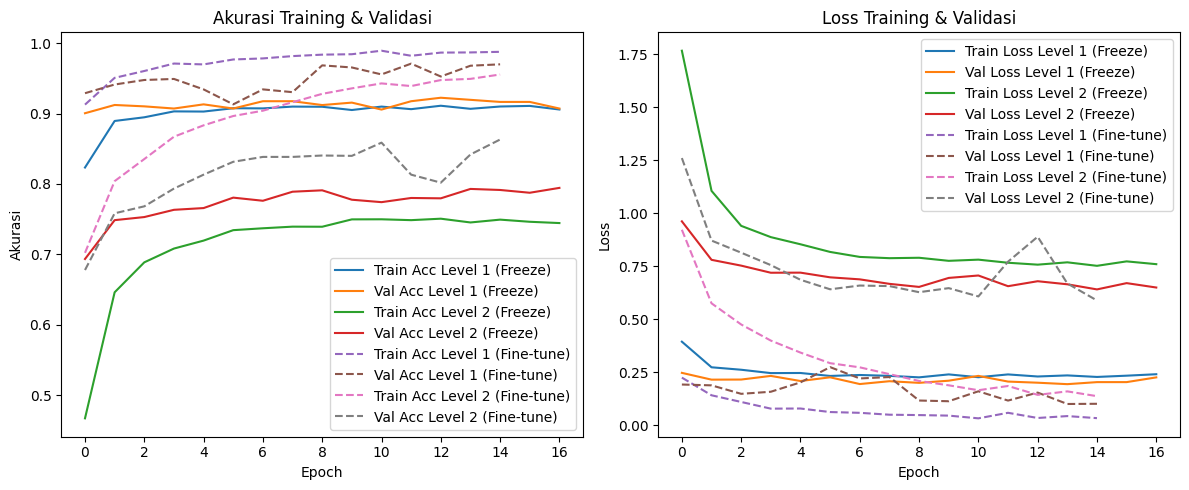

In [12]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['level1_accuracy'], label='Train Acc Level 1 (Freeze)')
plt.plot(history.history['val_level1_accuracy'], label='Val Acc Level 1 (Freeze)')
plt.plot(history.history['level2_accuracy'], label='Train Acc Level 2 (Freeze)')
plt.plot(history.history['val_level2_accuracy'], label='Val Acc Level 2 (Freeze)')
if 'level1_accuracy' in history_ft.history:
    plt.plot(history_ft.history['level1_accuracy'], label='Train Acc Level 1 (Fine-tune)', linestyle='--')
    plt.plot(history_ft.history['val_level1_accuracy'], label='Val Acc Level 1 (Fine-tune)', linestyle='--')
    plt.plot(history_ft.history['level2_accuracy'], label='Train Acc Level 2 (Fine-tune)', linestyle='--')
    plt.plot(history_ft.history['val_level2_accuracy'], label='Val Acc Level 2 (Fine-tune)', linestyle='--')
plt.title('Akurasi Training & Validasi')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['level1_loss'], label='Train Loss Level 1 (Freeze)')
plt.plot(history.history['val_level1_loss'], label='Val Loss Level 1 (Freeze)')
plt.plot(history.history['level2_loss'], label='Train Loss Level 2 (Freeze)')
plt.plot(history.history['val_level2_loss'], label='Val Loss Level 2 (Freeze)')
if 'level1_loss' in history_ft.history:
    plt.plot(history_ft.history['level1_loss'], label='Train Loss Level 1 (Fine-tune)', linestyle='--')
    plt.plot(history_ft.history['val_level1_loss'], label='Val Loss Level 1 (Fine-tune)', linestyle='--')
    plt.plot(history_ft.history['level2_loss'], label='Train Loss Level 2 (Fine-tune)', linestyle='--')
    plt.plot(history_ft.history['val_level2_loss'], label='Val Loss Level 2 (Fine-tune)', linestyle='--')
plt.title('Loss Training & Validasi')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

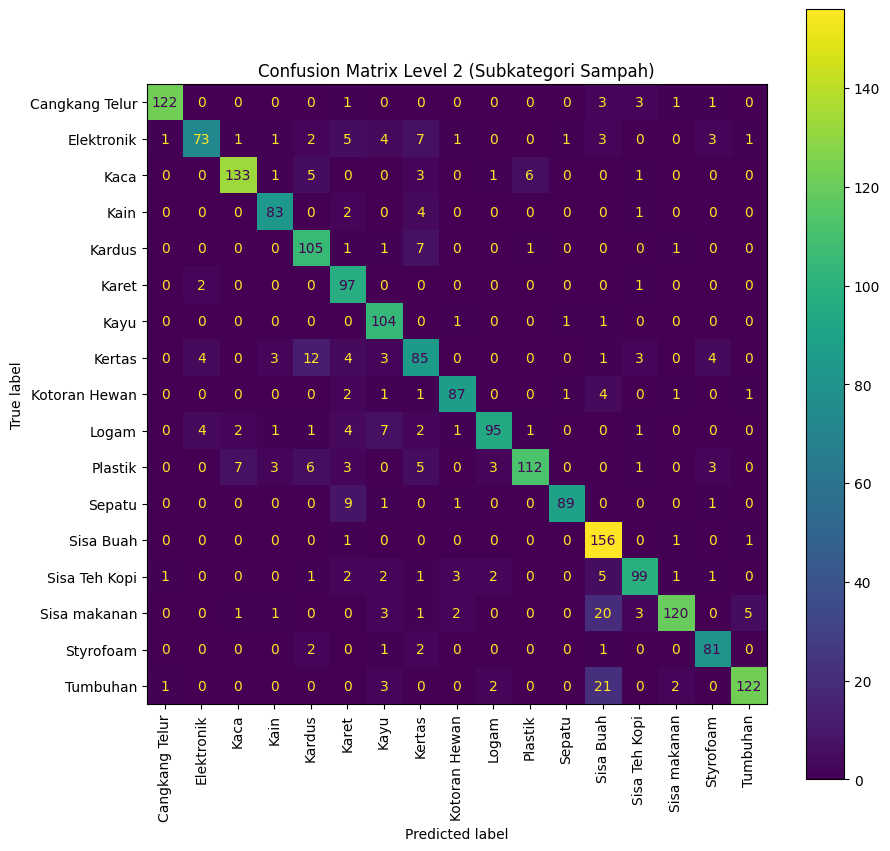

In [13]:
val_gen_base.reset()
y_true, y_pred = [], []

for _ in range(validation_steps):
    x_batch, y_batch = next(val_gen)
    y_true_indices = np.argmax(y_batch['level2'], axis=1)
    preds = model.predict(x_batch)
    y_pred_indices = np.argmax(preds[1], axis=1)
    y_true.extend(y_true_indices)
    y_pred.extend(y_pred_indices)

labels = [label_level2_map[i] for i in range(NUM_CLASSES_LEVEL2)]
cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation='vertical', ax=ax, cmap='viridis')
plt.title("Confusion Matrix Level 2 (Subkategori Sampah)")
plt.show()